# Chapter 6 
 Modern Statistics: A Computer Based Approach with Python<br>
by Ron Kenett, Shelemyahu Zacks, Peter Gedeck

Publisher: Springer International Publishing; 1st edition (September 15, 2022) <br>
ISBN-13: 978-3031075650

(c) 2022 Ron Kenett, Shelemyahu Zacks, Peter Gedeck

The code needs to be executed in sequence.

In [1]:
import os
os.environ['OUTDATED_IGNORE'] = '1'
import warnings
from outdated import OutdatedPackageWarning
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=OutdatedPackageWarning)

# Time Series Analysis and Prediction

In [2]:
import datetime
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ValueWarning
import pandas as pd

import random
import numpy as np
import pingouin as pg
from scipy import stats
import matplotlib.pyplot as plt
import mistat

## The Components of a Time Series

### The Trend and Covariances

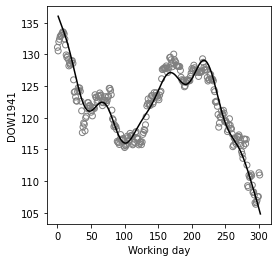

In [3]:
dow1941 = mistat.load_data('DOW1941')
t = np.arange(1, len(dow1941) + 1)
x = (t - 151) / 302
omega = 4 * np.pi * t / 302
ft = (123.34 + 27.73 * x - 15.83* x ** 2 - 237.00 * x**3
      + 0.1512 * np.cos(omega) + 1.738 * np.sin(omega)
      + 1.770 * np.cos(2 * omega) - 0.208 * np.sin(2 * omega)
      - 0.729 * np.cos(3 * omega) + 0.748 * np.sin(3 * omega))

fig, ax = plt.subplots(figsize=[4, 4])
ax.scatter(dow1941.index, dow1941, facecolors='none', edgecolors='grey')
ax.plot(t, ft, color='black')
ax.set_xlabel('Working day')
ax.set_ylabel('DOW1941')
plt.show()

### Analyzing Time Series With Python

In [4]:
dow1941 = mistat.load_data('DOW1941_DATE')

# convert Date column to Python datetime
dates = pd.to_datetime(dow1941['Date'], format='%Y-%m-%d')
dow1941_ts = pd.Series(dow1941['Open'], name='Dow_Jones_Index')
dow1941_ts.index = pd.DatetimeIndex(dates)

dow1941_ts.head()

Date
1941-01-02    131.1
1941-01-03    130.6
1941-01-04    132.0
1941-01-06    132.4
1941-01-07    132.8
Name: Dow_Jones_Index, dtype: float64

In [5]:
from statsmodels.tsa import tsatools
dow1941_df = tsatools.add_trend(dow1941_ts, trend='ct')
dow1941_df.head()

,Dow_Jones_Index,const,trend
Date,,,
1941-01-02,131.1,1.0,1.0
1941-01-03,130.6,1.0,2.0
1941-01-04,132.0,1.0,3.0
1941-01-06,132.4,1.0,4.0
1941-01-07,132.8,1.0,5.0


Intercept    125.929262
trend         -0.026070
dtype: float64
r2-adj: 0.151


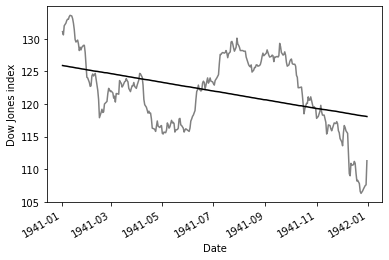

In [6]:
from statsmodels.tsa import tsatools
dow1941_df = tsatools.add_trend(dow1941_ts, trend='ct')
model_1 = smf.ols(formula='Dow_Jones_Index ~ trend + 1', data=dow1941_df).fit()
print(model_1.params)
print(f'r2-adj: {model_1.rsquared_adj:.3f}')

ax = dow1941_ts.plot(color='grey')
ax.set_xlabel('Time')
ax.set_ylabel('Dow Jones index')
model_1.predict(dow1941_df).plot(ax=ax, color='black')
plt.show()

Intercept             135.306337
np.power(trend, 3)     -0.000009
np.power(trend, 2)      0.003788
trend                  -0.450896
dtype: float64
r2-adj: 0.809


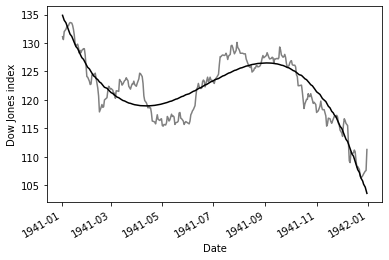

In [7]:
dow1941_df = tsatools.add_trend(dow1941_ts, trend='ct')
formula = 'Dow_Jones_Index ~ np.power(trend,3) + np.power(trend,2) + trend + 1'
model_2 = smf.ols(formula=formula, data=dow1941_df).fit()
print(model_2.params)
print(f'r2-adj: {model_2.rsquared_adj:.3f}')

ax = dow1941_ts.plot(color='grey')
ax.set_xlabel('Time')
ax.set_ylabel('Dow Jones index')
model_2.predict(dow1941_df).plot(ax=ax, color='black')
plt.show()

Intercept             134.580338
C(month)[T.2]          -3.247325
C(month)[T.3]           0.244691
C(month)[T.4]          -2.046448
C(month)[T.5]          -5.612228
C(month)[T.6]          -2.137326
C(month)[T.7]           2.308240
C(month)[T.8]           0.667104
C(month)[T.9]           1.662265
C(month)[T.10]         -1.316258
C(month)[T.11]         -1.758233
C(month)[T.12]         -0.419919
np.power(trend, 3)     -0.000007
np.power(trend, 2)      0.002990
trend                  -0.359448
dtype: float64
r2-adj: 0.909


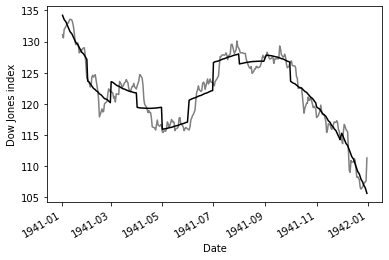

In [8]:
dow1941_df = tsatools.add_trend(dow1941_ts, trend='ct')
dow1941_df['month'] = dow1941_df.index.month
poly_formula = 'Dow_Jones_Index ~ C(month) + np.power(trend, 3) + np.power(trend, 2) + trend + 1'
model_3 = smf.ols(formula=poly_formula, data=dow1941_df).fit()
print(model_3.params)
print(f'r2-adj: {model_3.rsquared_adj:.3f}')

ax = dow1941_ts.plot(color='grey')
ax.set_xlabel('Time')
ax.set_ylabel('Dow Jones index')
model_3.predict(dow1941_df).plot(ax=ax, color='black')
plt.show()

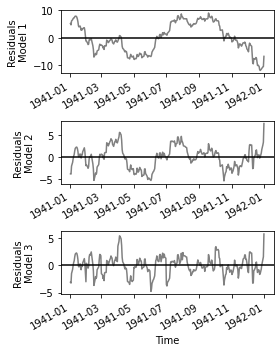

In [9]:
fig, axes = plt.subplots(figsize=[4, 5], nrows=3)
def residual_plot(model, ax, title):
  model.resid.plot(color='grey', ax=ax)
  ax.set_xlabel('')
  ax.set_ylabel(f'Residuals\n{title}')
  ax.axhline(0, color='black')
residual_plot(model_1, axes[0], 'Model 1')
residual_plot(model_2, axes[1], 'Model 2')
residual_plot(model_3, axes[2], 'Model 3')
axes[2].set_xlabel('Time')
plt.tight_layout()
plt.show()

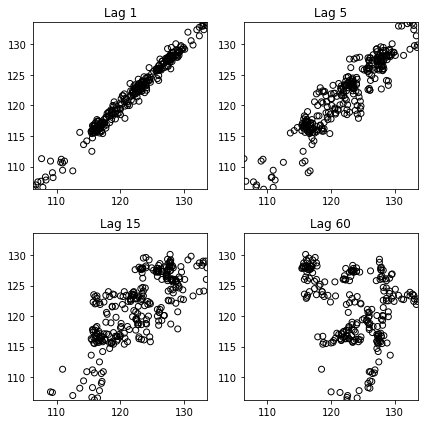

In [10]:
def plotLag(ts, lag, ax, limits):
  ax.scatter(ts[:-lag], ts[lag:], facecolors='none', edgecolors='black')
  ax.set_title(f'Lag {lag}')
  ax.set_xlim(*limits)
  ax.set_ylim(*limits)

fig, axes = plt.subplots(figsize=[6, 6], nrows=2, ncols=2)
limits = [dow1941_ts.min(), dow1941_ts.max()]
plotLag(dow1941_ts, 1, axes[0][0], limits)
plotLag(dow1941_ts, 5, axes[0][1], limits)
plotLag(dow1941_ts, 15, axes[1][0], limits)
plotLag(dow1941_ts, 60, axes[1][1], limits)

plt.tight_layout()
plt.show()

## Covariance Stationary Time Series

### Moving Averages

### Auto-Regressive Time Series

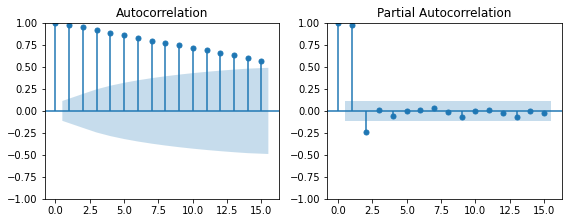

In [11]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

dow_acf = acf(dow1941_ts, nlags=15, fft=True)
dow_pacf = pacf(dow1941_ts, nlags=15)

fig, axes = plt.subplots(ncols=2, figsize=[8, 3.2])
plot_acf(dow1941_ts, lags=15, ax=axes[0])
plot_pacf(dow1941_ts, lags=15, method='ywm', ax=axes[1])
plt.tight_layout()
plt.show()

In [12]:
for i, (v1, v2) in enumerate(zip(dow_acf, dow_pacf)):
  print(f'{i} & {v1:.4f} & {v2:.4f} \\\\')

0 & 1.0000 & 1.0000 \\
1 & 0.9805 & 0.9838 \\
2 & 0.9521 & -0.2949 \\
3 & 0.9222 & 0.0220 \\
4 & 0.8907 & -0.0737 \\
5 & 0.8592 & 0.0117 \\
6 & 0.8290 & 0.0165 \\
7 & 0.8009 & 0.0360 \\
8 & 0.7738 & -0.0203 \\
9 & 0.7451 & -0.0859 \\
10 & 0.7162 & 0.0048 \\
11 & 0.6885 & 0.0179 \\
12 & 0.6607 & -0.0346 \\
13 & 0.6309 & -0.0839 \\
14 & 0.6008 & 0.0053 \\
15 & 0.5708 & -0.0349 \\


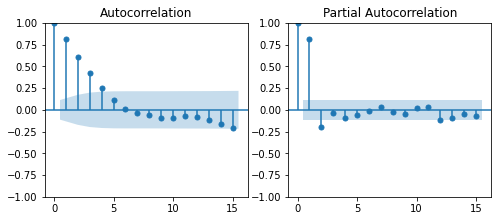

In [13]:
dow_acf = acf(model_3.resid, nlags=15, fft=True)
fig, axes = plt.subplots(ncols=2, figsize=[8, 3.2])
plot_acf(model_3.resid, lags=15, ax=axes[0])
plot_pacf(model_3.resid, lags=15, method='ywm', ax=axes[1])
plt.show()

In [14]:
for i, v1 in enumerate(dow_acf):
  print(f'{i} & {v1:.4f}  \\\\')

0 & 1.0000  \\
1 & 0.8172  \\
2 & 0.6041  \\
3 & 0.4213  \\
4 & 0.2554  \\
5 & 0.1142  \\
6 & 0.0137  \\
7 & -0.0366  \\
8 & -0.0646  \\
9 & -0.0895  \\
10 & -0.0905  \\
11 & -0.0682  \\
12 & -0.0790  \\
13 & -0.1214  \\
14 & -0.1641  \\
15 & -0.2087  \\


### Auto-Regressive Moving Averages Time Series

### Integrated Auto-Regressive Moving Average Time Series

### Applications with Python

In [15]:
# ignore ValueWarning for Kurtosis-test due to small dataset
import warnings
warnings.simplefilter('ignore', category=(ValueWarning, UserWarning))

Best model: (2, 0, 2)


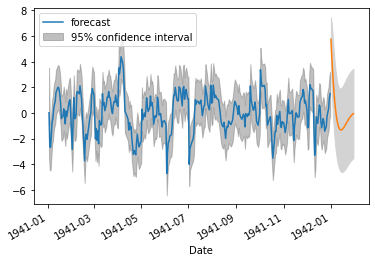

In [16]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

# Identify optimal ARMA options using the AIC score
bestModel = None
bestAIC = None
for ar in range(0, 5):
  for ma in range(0, 5):
    model = ARIMA(model_3.resid, order=(ar, 0, ma)).fit()
    if bestAIC is None or bestAIC > model.aic:
      bestAIC = model.aic
      bestModel = (ar, 0, ma)
print(f'Best model: {bestModel}')

model = ARIMA(model_3.resid, order=bestModel).fit()

prediction = model.get_forecast(30).summary_frame()
prediction['date'] = [max(dow1941_ts.index) + datetime.timedelta(days=i)
                      for i in range(1, len(prediction) + 1)]

plot_predict(model)
ax = plt.gca()

ax.plot(prediction['date'], prediction['mean'])
ax.fill_between(prediction['date'],
                prediction['mean_ci_lower'], prediction['mean_ci_upper'],
                color='lightgrey')
plt.show()

In [17]:
# restore default setting
warnings.simplefilter('default', category=ValueWarning)

## Linear Predictors for Covariance Stationary Time Series

### Optimal Linear Predictors

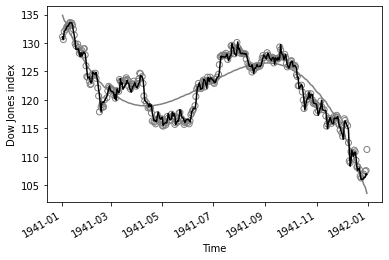

PMSE(trend) = 6.3315
PMSE(corrected) = 0.5580


In [18]:
predictedError = mistat.optimalLinearPredictor(model_2.resid,11,nlags=10)
predictedTrend = model_2.predict(dow1941_df)
correctedTrend = predictedTrend + predictedError

fig, ax = plt.subplots()
ax.scatter(dow1941_ts.index, dow1941_ts,
           facecolors='none', edgecolors='grey')
predictedTrend.plot(ax=ax, color='grey')
correctedTrend.plot(ax=ax, color='black')
ax.set_xlabel('Time')
ax.set_ylabel('Dow Jones index')
plt.show()

print(f'PMSE(trend) = {np.mean((predictedTrend - dow1941_ts)**2):.4f}')
print(f'PMSE(corrected) = {np.mean((correctedTrend-dow1941_ts)**2):.4f}')

## Predictors for Non-Stationary Time Series

### Quadratic LSE Predictors

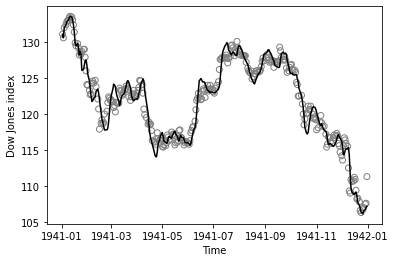

PMSE(quadratic) = 1.9483


In [19]:
quadPrediction = mistat.quadraticPredictor(dow1941_ts, 20, 1)

fig, ax = plt.subplots()
ax.scatter(dow1941_ts.index, dow1941_ts,
           facecolors='none', edgecolors='grey')
ax.plot(dow1941_ts.index, quadPrediction, color='black')
ax.set_xlabel('Time')
ax.set_ylabel('Dow Jones index')
plt.show()

print(f'PMSE(quadratic) = {np.mean((quadPrediction-dow1941_ts)**2):.4f}')

### Moving Average Smoothing Predictors

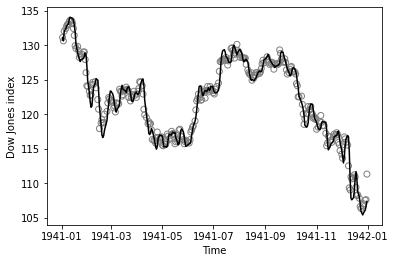

PMSE(MAS) = 1.4917


In [20]:
masPrediction = mistat.masPredictor(dow1941_ts, 3, 1)

fig, ax = plt.subplots()
ax.scatter(dow1941_ts.index, dow1941_ts,
           facecolors='none', edgecolors='grey')
ax.plot(dow1941_ts.index, masPrediction, color='black')
ax.set_xlabel('Time')
ax.set_ylabel('Dow Jones index')
plt.show()

print(f'PMSE(MAS) = {np.mean((masPrediction - dow1941_ts)**2):.4f}')

## Dynamic Linear Models

### Some Special Cases

#### The Normal Random Walk

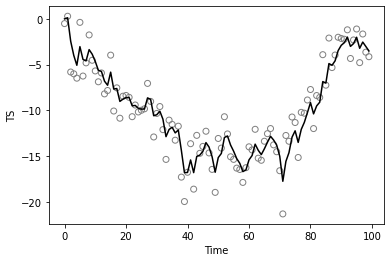

In [21]:
res = mistat.normRandomWalk(100, 3, 1, 1, seed=2)

fig, ax = plt.subplots()
ax.scatter(res.t, res.X, facecolors='none', edgecolors='grey')
ax.plot(res.t, res.predicted, color='black')
ax.set_xlabel('Time')
ax.set_ylabel('TS')

plt.show()

#### Dynamic Linear Model With Linear Growth

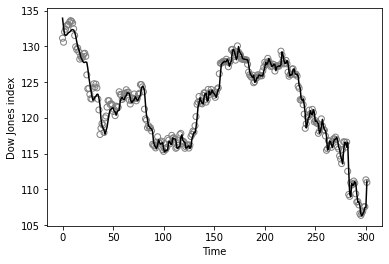

In [22]:
C0 = np.array([[0.22325, -0.00668], [-0.00668, 0.00032]])
M0 = np.array([134.234, -0.3115])
W = np.array([[0.3191, -0.0095], [-0.0095, 0.0004]])
v = 1

dow1941 = mistat.load_data('DOW1941.csv')
predicted = mistat.dlmLinearGrowth(dow1941, C0, v, W, M0)

fig, ax = plt.subplots()
ax.scatter(dow1941.index, dow1941, facecolors='none', edgecolors='grey')
ax.plot(dow1941.index, predicted, color='black')
ax.set_xlabel('Time')
ax.set_ylabel('Dow Jones index')
plt.show()

#### Dynamic Linear Model for ARMA(p,q)

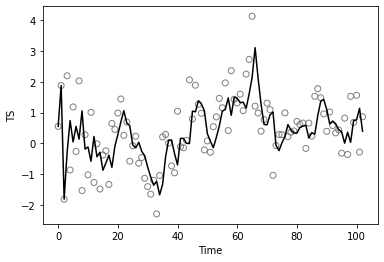

PMSE(ARMA) = 0.8505


In [23]:
a = [0.5, 0.3, 0.1]
b = [0.3, 0.5]
ts = pd.Series(mistat.simulateARMA(100, a, b, seed=1))
predicted = mistat.predictARMA(ts, a)

fig, ax = plt.subplots()
ax.scatter(ts.index, ts, facecolors='none', edgecolors='grey')
ax.plot(ts.index, predicted, color='black')
ax.set_xlabel('Time')
ax.set_ylabel('TS')
plt.show()

print(f'PMSE(ARMA) = {np.mean((predicted - ts)**2):.4f}')

## Chapter Highlights

## Exercises